# Denoising autoencoders

In this question, you will be training a autoencoder to remove noise from an
image. Create the noisy images by adding Gaussian noise with mean 0 and
standard deviation 97 to every pixel of an image. Clip the pixel values of the
images between 0 and 255. When displaying the images, you can round the
pixel values to the nearest integer.
Pytorch provides train and test splits for the MNIST dataset. You are not
suppose to use the test split for training in any form, including early stopping.
If required, create an eval split from the train split, but having an eval split is
not compulsory in this question.

### Import Libraries

In [1]:
import numpy as np
import matplotlib
from PIL import Image

from torch import nn
from torch import optim
import torch.nn.functional as F

### Dataset Preparation

torch.Size([28, 28])


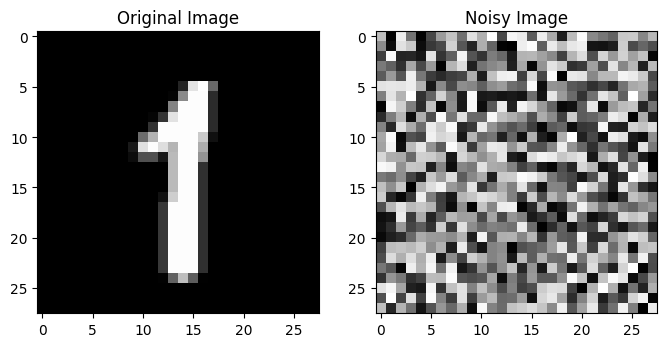

torch.Size([28, 28])


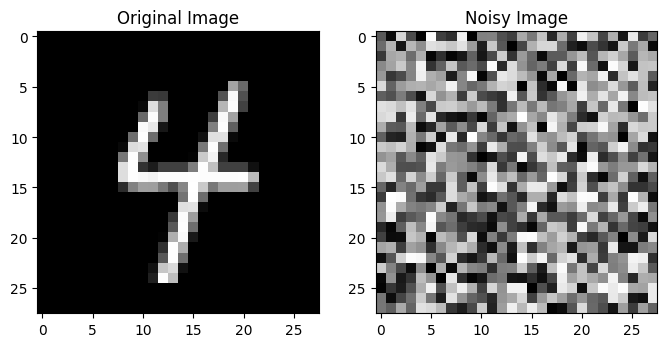

torch.Size([28, 28])


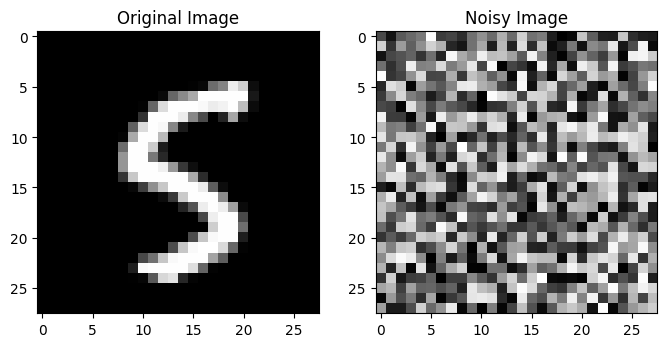

torch.Size([28, 28])


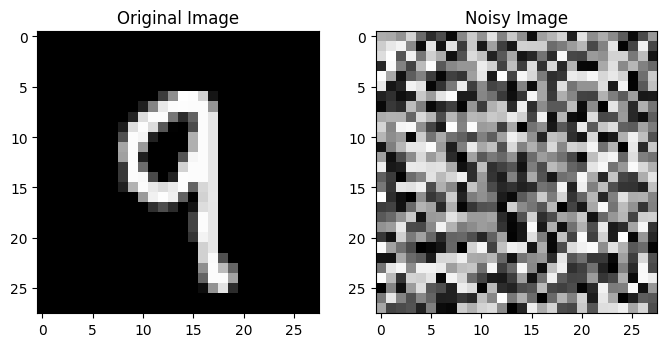

torch.Size([28, 28])


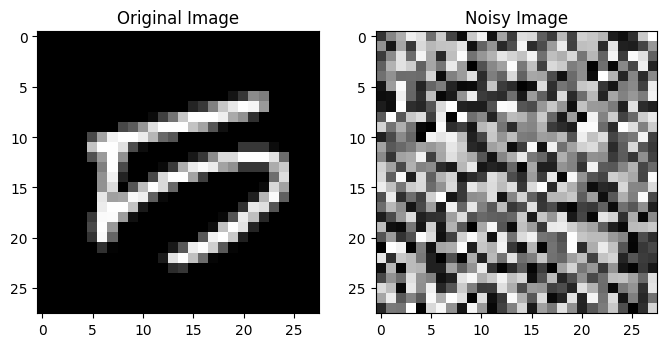

In [2]:
# Import necessary libraries
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Define a custom transformation to add Gaussian Noise
class AddGaussianNoise(object):
    def __init__(self, mean=0, std=97):
        self.mean = mean
        self.std = std

    def __call__(self, image):
        image = np.array(image)  # Convert PIL Image to a NumPy array
        noise = np.random.normal(self.mean, self.std, image.shape).astype(np.uint8)
        noisy_image = np.clip(image + noise, 0, 255)  # Clip pixel values to the range [0, 255]
        return Image.fromarray(noisy_image)  # Convert back to PIL Image

# Define the data transformation for preprocessing
transform = transforms.Compose([
    AddGaussianNoise(mean=0, std=97),  # Add Gaussian Noise to the image
    transforms.ToTensor(),  # Convert PIL Image to Tensor
])

# Write a Custom MNIST Dataset whose labels are the un-transformed images
class CustomMNISTDataset(torchvision.datasets.MNIST):
    def __getitem__(self, index):
        image, label = super().__getitem__(index)
        noisy_image = transform(image)  # Apply the transformation to get noisy image
        # Convert noisy_image and image from PIL images to tensors
        image = transforms.ToTensor()(image)
        return noisy_image, image # Return tensors instead of PIL images

# Set the device to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Create the dataset
dataset = CustomMNISTDataset(root="data", train=True, download=True)

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

# Define the DataLoader for the test set
test_dataset = CustomMNISTDataset(root="data", train=False, download=True)

# Create the test dataloader
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=True)

# # Show a couple of image pairs (original and noisy images)
# for batch in dataloader:
#     noisy_images, original_images = batch

#     for i in range(5):
#         print(original_images[i][0].shape)
#         fig, axes = plt.subplots(1, 2, figsize=(8, 4))
#         axes[0].imshow(original_images[i][0], cmap='gray')
#         axes[0].set_title("Original Image")
#         axes[1].imshow(noisy_images[i][0], cmap='gray')
#         axes[1].set_title("Noisy Image")
#         plt.show()

#     # Show only a few pairs for demonstration purposes
#     break


### Auto Encoder Class

In [3]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),  # (N, 16, 28, 28)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (N, 16, 14, 14)
            nn.Conv2d(16, 32, kernel_size=3, padding=1),  # (N, 32, 14, 14)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (N, 32, 7, 7)
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # (N, 64, 7, 7)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # (N, 64, 3, 3)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2),  # (N, 32, 7, 7)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),  # (N, 16, 14, 14)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=2, stride=2),  # (N, 1, 28, 28)
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [4]:
# Define the Model
model = AutoEncoder().to(device)

# Define the Loss -> MSE
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the DataLoader for the training set
num_epochs = 15

losses = []

for epoch in range(num_epochs):
    for batch in dataloader:
        noisy_images, original_images = batch
        noisy_images = noisy_images.to(device)
        original_images = original_images.to(device)

        # Forward Pass
        outputs = model(noisy_images)
        loss = criterion(outputs, original_images)

        # Backward Pass and Optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Find the test loss for each epoch
    test_loss = 0
    for batch in test_dataloader:
        noisy_images, original_images = batch
        noisy_images = noisy_images.to(device)
        original_images = original_images.to(device)
        outputs = model(noisy_images)
        loss = criterion(outputs, original_images)
        test_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {loss.item():.4f}")
    print(f"Epoch [{epoch + 1}/{num_epochs}], Test Loss: {test_loss / len(test_dataloader):.4f}")

    losses.append((loss.item(), test_loss / len(test_dataloader)))

# # Graph the losses
# plt.plot(losses)
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.legend(["Train Loss", "Test Loss"])

# Save the Model
torch.save(model.state_dict(), "autoencoder.pth")

Epoch [1/15], Train Loss: 0.0930
Epoch [1/15], Test Loss: 0.0941
Epoch [2/15], Train Loss: 0.0784
Epoch [2/15], Test Loss: 0.0771
Epoch [3/15], Train Loss: 0.0631
Epoch [3/15], Test Loss: 0.0712
Epoch [4/15], Train Loss: 0.0627
Epoch [4/15], Test Loss: 0.0677
Epoch [5/15], Train Loss: 0.0603
Epoch [5/15], Test Loss: 0.0675
Epoch [6/15], Train Loss: 0.0684
Epoch [6/15], Test Loss: 0.0676
Epoch [7/15], Train Loss: 0.0666
Epoch [7/15], Test Loss: 0.0675
Epoch [8/15], Train Loss: 0.0692
Epoch [8/15], Test Loss: 0.0675
Epoch [9/15], Train Loss: 0.0667
Epoch [9/15], Test Loss: 0.0675


In [ ]:
# Load the Model
model = AutoEncoder()

# Load the trained model parameters
model.load_state_dict(torch.load("autoencoder.pth"))

# Pass One Example from the Test Set through the Model
output = model.forward(test_dataset[0][0].unsqueeze(0))

# Visualize the Results
fig, axes = plt.subplots(1, 2, figsize=(4, 2))
axes[0].imshow(test_dataset[0][0][0], cmap='gray')
axes[0].set_title("Original Image")

axes[1].imshow(output[0][0].detach().numpy(), cmap='gray')
axes[1].set_title("Reconstructed Image")
plt.show()